# Fitting a stainless steel XRF spectrum
Load the necessary libraries.

In [1]:
using Revise
using NeXLCore
using NeXLSpectrum
using NeXLUncertainties
using Gadfly
using DataFrames
ENV["columns"]=160;

Read in the spectra and tabulate.

In [2]:
path = "C:/Users/nicho/.julia/dev/NeXLSpectrum/test/XRF Stainless"
steel = readEMSA("$(path)/Steel_50kv_50_ma_Rh_vac_D1.msa")
det = matching(steel, steel[:FWHMMnKa], 120)
fe = readEMSA("$(path)/Fe_50kv_50_ma_Rh_vac_D1.msa",det,true)
ni = readEMSA("$(path)/Ni_50kv_50_ma_Rh_vac_D1.msa",det,true)
cr = readEMSA("$(path)/Cr_50kv_50_ma_Rh_vac_D1.msa",det,true)
ti = readEMSA("$(path)/Ti_50kv_50_ma_Rh_vac_D1.msa",det,true)
si = readEMSA("$(path)/Si_50kv_50_ma_Rh_vac_D1.msa",det,true)
s = readEMSA("$(path)/S_50kv_50_ma_Rh_vac_D1.msa",det,true)
sn = readEMSA("$(path)/Sn_50kv_50_ma_Rh_vac_D1.msa",det,true)
NeXLSpectrum.asa(DataFrame, [ steel, fe, ni, cr, ti, si, s, sn])

,Name,BeamEnergy,ProbeCurrent,LiveTime,RealTime,Coating,Integral,Material
,String,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Union…,Float64,String⍰
1,Steel_50kv_50_ma_Rh_vac_D1,missing,missing,119.973,131.887,,6.53649e6,missing
2,Fe_50kv_50_ma_Rh_vac_D1,missing,missing,120.005,134.805,,6.44701e6,missing
3,Ni_50kv_50_ma_Rh_vac_D1,missing,missing,120.027,137.71,,7.28941e6,missing
4,Cr_50kv_50_ma_Rh_vac_D1,missing,missing,119.994,131.733,,5.38102e6,missing
5,Ti_50kv_50_ma_Rh_vac_D1,missing,missing,120.012,128.039,,3.88987e6,missing
6,Si_50kv_50_ma_Rh_vac_D1,missing,missing,119.986,121.022,,665491.0,missing
7,S_50kv_50_ma_Rh_vac_D1,missing,missing,120.013,122.159,,1.25884e6,missing
8,Sn_50kv_50_ma_Rh_vac_D1,missing,missing,119.974,121.481,,903249.0,missing


Plot the spectra.

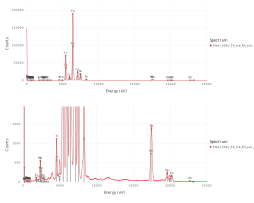

In [3]:
set_default_plot_size(10inch,8inch)
vstack( 
    plot(steel,xmax=25.0e3, yscale=1.1,klms=[n"Fe",n"Cr",n"Ni",n"Ti", n"Si",n"S", n"Mo", n"Rh"]),
    plot(steel,xmax=25.0e3, yscale=0.01,klms=[n"Fe",n"Cr",n"Ni",n"Ti", n"Si",n"S", n"Mo", n"Rh"])
)

Build a top-hat filter to process the standards and unknown spectra.

In [4]:
filt = buildfilter(VariableWidthFilter,det)

VariableWidthFilter[EDS[4096 channels, E[ch] = -955.3045 + 9.998999999999999⋅ch, 143.7976 eV @ Mn Kα]]

Apply the filter to the standards.

In [5]:
# Add characteristic peaks 
rr = [
    ( n"Fe", ktransitions, fe ),
    ( n"Cr", ktransitions, cr ),
    ( n"Ni", ktransitions, ni ),
    ( n"Ti", ktransitions, ti ),
    ( n"Si", ktransitions, si ),
    ( n"S", ktransitions, s ),
    ( n"Sn", ltransitions, sn )
]
rx = map(r ->(NeXLSpectrum.charFeature(r[1], r[2]), r[3]), rr)
refs = collect(Iterators.flatten((r -> filter(r[2], det, r[1], filt, 1.0)).(rx)))

10-element Array{FilteredReference,1}:
 Reference[Fe K-L3 + 1 other]   
 Reference[Fe K-M3 + 1 other]   
 Reference[Cr K-L3 + 1 other]   
 Reference[Cr K-M3 + 1 other]   
 Reference[Ni K-L3 + 1 other]   
 Reference[Ni K-M3 + 1 other]   
 Reference[Ti K-L3 + 3 others]  
 Reference[Si K-L3 + 2 others]  
 Reference[S K-L3 + 3 others]   
 Reference[Sn L3-M5 + 14 others]

Fit the unknown spectrum.

In [6]:
steel[:ProbeCurrent]=1.0
res=fit(steel,filt,refs,false)

Unknown[Steel_50kv_50_ma_Rh_vac_D1]

Plot the residuals and k-ratios.

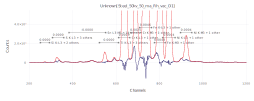

In [7]:
set_default_plot_size(10inch,4inch)
plot(res,200:1200)

Tabulate the results.

In [8]:
convert(DataFrame,res)

,Label,Feature,Start,Stop,K,dK,Peak,Back
,NeXLSpec…,NeXLSpec…,Int64,Int64,Float64,Float64,Float64,Float64
1,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Cr K-L3 + 1 other,612,663,0.00193647,1.0551e-6,1.05211e6,4661.23
2,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Cr K-M3 + 1 other,668,714,0.00250267,4.44805e-6,221673.0,24042.9
3,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Fe K-L3 + 1 other,709,763,0.00463835,1.48867e-6,3.04548e6,16746.5
4,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Fe K-M3 + 1 other,777,826,0.00483135,4.89337e-6,477864.0,20979.4
5,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Ni K-L3 + 1 other,815,872,0.000408216,4.74953e-7,317014.0,16831.0
6,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Ni K-M3 + 1 other,897,949,0.000417128,1.41159e-6,58792.0,14742.6
7,Unknown[Steel_50kv_50_ma_Rh_vac_D1],S K-L3 + 3 others,307,359,4.71076e-5,5.49842e-7,12073.0,6273.48
8,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Si K-L3 + 2 others,251,293,1.92433e-5,5.50367e-7,2278.0,1310.43
9,Unknown[Steel_50kv_50_ma_Rh_vac_D1],Sn L3-M5 + 14 others,383,552,-1.92345e-7,0.000969451,28513.0,28528.4


<div style="text-align: right">NWMR 21-Nov-2019</div>